In [11]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("hourly_31.csv")
df.head()

,Usage (kW),Season,Month,Day,DayName,Weekend,House num
0,1.220527,Post-monsoon,11,1,Wednesday,0,31
1,2.567761,Post-monsoon,11,1,Wednesday,0,31
2,2.469974,Post-monsoon,11,1,Wednesday,0,31
3,0.810168,Post-monsoon,11,1,Wednesday,0,31
4,1.341152,Post-monsoon,11,1,Wednesday,0,31


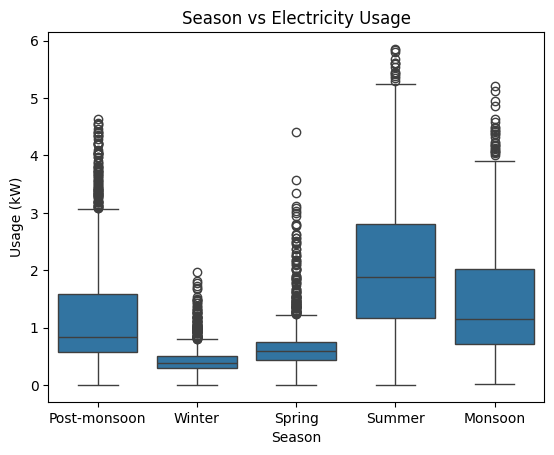

In [12]:
import seaborn as sns
sns.boxplot(x="Season", y="Usage (kW)", data=df)
plt.title("Season vs Electricity Usage")
plt.show()

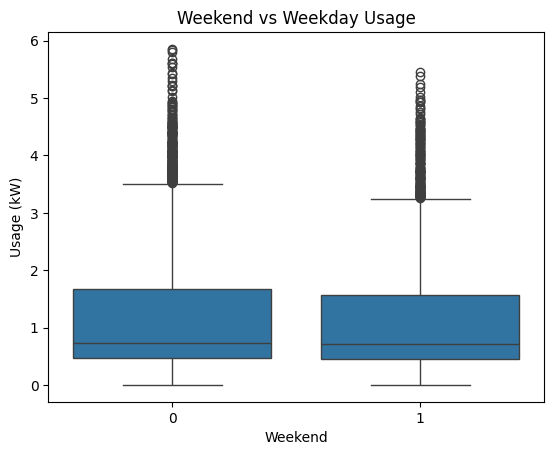

In [13]:
sns.boxplot(x="Weekend", y="Usage (kW)", data=df)
plt.title("Weekend vs Weekday Usage")
plt.show()


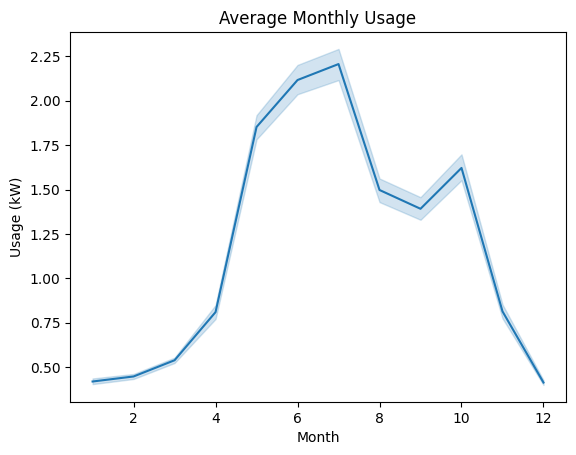

In [14]:
sns.lineplot(x="Month", y="Usage (kW)", data=df, estimator="mean")
plt.title("Average Monthly Usage")
plt.show()


In [ ]:
train_df = df[df['Month'] < 10]
test_df = df[df['Month'] >= 10]

X_train = train_df.drop(columns=['Usage (kW)'])
y_train = train_df['Usage (kW)']

X_test = test_df.drop(columns=['Usage (kW)'])
y_test = test_df['Usage (kW)']


In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Assuming df is your DataFrame and sorted chronologically
# If not sorted, sort by Month and Day (but time order might be lost without datetime)
# Better to keep datetime column or ensure proper ordering

# Ensure chronological ordering - if you have Month and Day, you can sort:
df = df.sort_values(['Month', 'Day']).reset_index(drop=True)

# Chronological split (80-20)
df = df.sort_values('date')

train_df = df[df['date'] < '2023-01-01']
test_df  = df[df['date'] >= '2023-01-01']

# Identify categorical and numerical columns
categorical_cols = ['Season', 'DayName']
numerical_cols = ['Month', 'Day', 'Weekend']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

X_train = train_df.drop(columns=['Usage (kW)'])
y_train = train_df['Usage (kW)']

X_test = test_df.drop(columns=['Usage (kW)'])
y_test = test_df['Usage (kW)']

# Dictionary of models to try
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'model': pipeline
    }
    
    print(f"{name}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")
    print("-" * 40)

# Find best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
print(f"\n✅ Best Model: {best_model_name} (R² = {results[best_model_name]['R2']:.4f})")

KeyError: 'date'